# Syneval results

In [1]:
%matplotlib inline

import sys
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
UNK = '<UNK>'

# The original names of the folders as given in the dataset.
ORIGINAL = [
    'simple_agrmt',
    'sent_comp',
    'vp_coord',
    'long_vp_coord',
    'prep_anim',
    'prep_inanim',
    'subj_rel',
    'obj_rel_across_anim',
    'obj_rel_across_inanim',
    'obj_rel_no_comp_across_anim',
    'obj_rel_no_comp_across_inanim',
    'obj_rel_no_comp_within_anim',
    'obj_rel_no_comp_within_inanim',
    'obj_rel_within_anim',
    'obj_rel_within_inanim',
    'simple_reflexives',
    'reflexive_sent_comp',
    'reflexives_across',
    'simple_npi_anim',
    'simple_npi_anim_the',
    'simple_npi_inanim',
    'simple_npi_inanim_the',
    'npi_across_anim',
    'npi_across_anim_the',
    'npi_across_inanim',
    'npi_across_inanim_the',
]

# The names of the collapsed classes that 
# correspond to what's reported in the paper.
ALL = [
    'simple_agrmt', 
    'sent_comp',
    'vp_coord',
    'long_vp_coord',
    'prep',
    'subj_rel',
    'obj_rel_across',
    'obj_rel_no_comp_across',
    'obj_rel_within',
    'obj_rel_no_comp_within',
    'simple_reflexives',
    'reflexive_sent_comp',
    'reflexives_across',
    'simple_npi',
    'simple_npi_the',
    'npi_across',
    'npi_across_the',
]

# Maps the names in ORIGINAL to names in ALL
COLLAPSE_DICT = {
    'simple_agrmt': 'simple_agrmt', 
    'sent_comp': 'sent_comp',
    'vp_coord': 'vp_coord',
    'long_vp_coord': 'long_vp_coord',
    'prep_anim': 'prep',
    'prep_inanim': 'prep',
    'subj_rel': 'subj_rel',
    'obj_rel_across_anim': 'obj_rel_across',
    'obj_rel_across_inanim': 'obj_rel_across',
    'obj_rel_no_comp_across_anim': 'obj_rel_no_comp_across',
    'obj_rel_no_comp_across_inanim': 'obj_rel_no_comp_across',
    'obj_rel_no_comp_within_anim': 'obj_rel_no_comp_within',
    'obj_rel_no_comp_within_inanim': 'obj_rel_no_comp_within',
    'obj_rel_within_anim': 'obj_rel_within',
    'obj_rel_within_inanim': 'obj_rel_within',
    'simple_reflexives': 'simple_reflexives',
    'reflexive_sent_comp': 'reflexive_sent_comp',
    'reflexives_across': 'reflexives_across',
    'simple_npi_anim': 'simple_npi',
    'simple_npi_anim_the': 'simple_npi_the',
    'simple_npi_inanim': 'simple_npi',
    'simple_npi_inanim_the': 'simple_npi_the',
    'npi_across_anim': 'npi_across',
    'npi_across_anim_the': 'npi_across_the',
    'npi_across_inanim': 'npi_across',
    'npi_across_inanim_the': 'npi_across_the',
}

# Names suitable for the plot
FANCY = [
    "1. Simple",
    "1. In sentential complement",
    "1. Short VP coordination",
    "1. Long VP coordination",
    "1. Across prepositional",
    "1. Across subject relative",
    "1. Across object relative",
    "1. Across object relative (no that)",
    "1. In object relative",
    "1. In object relative (no that)",
    "2. Simple",
    "2. In sentential complement",
    "2. Across relative clause",
    "3. Simple",
    "3. Simple (the)",
    "3. Across a relative clause",
    "3. Across a relative clause (the)",
]

# Alternative fancy names
FANCY_ALT = [
    "(agreement) Simple",
    "(agreement) In sentential complement",
    "(agreement) Short VP coordination",
    "(agreement) Long VP coordination",
    "(agreement) Across prepositional",
    "(agreement) Across subject relative",
    "(agreement) Across object relative",
    "(agreement) Across object relative (no that)",
    "(agreement) In object relative",
    "(agreement) In object relative (no that)",
    "(reflexives) Simple",
    "(reflexives) In sentential complement",
    "(reflexives) Across relative clause",
    "(npi) Simple",
    "(npi) Simple (the)",
    "(npi) Across a relative clause",
    "(npi) Across a relative clause (the)",
]

# Numbers instead of names
NUMBERS = list(range(1, len(ALL)+1))

# Use the fancy names for the classes
NAME_DICT_FANCY = dict(zip(ALL, FANCY))

# Use the fancy names for the classes
NAME_DICT_NUMBERS = dict(zip(ALL, NUMBERS))



In [3]:
def select(df, name):
    return df[df['name'] == name]


def accuracy(df, name, exclude_unks=False):
    if exclude_unks:
        pos_unk = df['pos-sentence-processed'].str.contains(UNK)
        neg_unk = df['neg-sentence-processed'].str.contains(UNK)
        df = df[-pos_unk & -neg_unk]

    field = select(df, name)['correct']
    return field.sum() / len(field)


def get_results_as_dict(df, exclude_unks=False):
    results = dict()
    for name in set(df['name']):
        results[name] = round(accuracy(df, name, exclude_unks), 2)
    results['total'] = round(df['correct'].sum() / len(df), 2)
    return results


def rename_classes(df, rename_dict):
    for old_name, new_name in rename_dict.items():
        df = df.replace(old_name, new_name)
    return df


def get_results_as_dataframe(dataframes, model_type='', exclude_unks=False, 
                             collapse_classes=True, rename_dict=None):   
    assert isinstance(dataframes, list)
    assert all(isinstance(df, pd.DataFrame) for df in dataframes)


    if collapse_classes:
        dataframes = [rename_classes(df, COLLAPSE_DICT) for df in dataframes]

    if rename_dict is not None:
        assert set(dataframes[0]['name']) == set(rename_dict.keys())
        dataframes = [rename_classes(df, rename_dict) for df in dataframes]

    names = set(dataframes[0]['name'])
    columns = ['name', 'accuracy', 'model', 'run'] 
    
    results = []
    for name in names:
        for i, df in enumerate(dataframes):
            acc = round(accuracy(df, name, exclude_unks), 2)
            results.append(
                [name, acc, model_type, i])

    return pd.DataFrame(results, columns=columns)

In [4]:
def filter_folders(folders, name, include=[], exclude=[]):
    filtered = []
    for folder in folders:
        folder = folder.split('_')
        if folder[0] == name:
            if all(name in folder for name in include) and all(not name in folder for name in exclude):
                filtered.append('_'.join(folder))
    if not filtered:
        filtered.append('')

    return filtered


def get_max_dev(folders):
    return '_'.join(max(
        [folder.split('_') for folder in folders], 
        key=lambda l: l[-1]))


def get_min_dev(folders):
    return '_'.join(max(
        [folder.split('_') for folder in folders], 
        key=lambda l: l[-1]))

## Collect all folders

In [5]:
model_dir = '../models'
temp_dir = 'temp'

all_folders = [d for d in os.listdir(model_dir)
    if os.path.isdir(os.path.join(model_dir, d))
    and d != temp_dir]

## LM

In [6]:
lm_folders = filter_folders(all_folders, 'lm')
lm_folders

['lm_dev=96.52',
 'lm_dev=96.64',
 'lm_dev=96.76',
 'lm_dev=97.01',
 'lm_dev=97.05',
 'lm_dev=97.07',
 'lm_dev=97.46',
 'lm_dev=98.07',
 'lm_dev=98.39',
 'lm_dev=98.75']

In [7]:
# lm_dfs = [
#     pd.read_csv(f'../models/{folder}/output/syneval_results.tsv', sep='\t') 
#     for folder in lm_folders
# ]

# lm_df = get_results_as_dataframe(lm_dfs, 'lm')

# fig, ax = plt.subplots(figsize=(15, 10))
# g = sns.barplot(
#     data=lm_df, x='name', y='accuracy', ax=ax, palette="Blues_d", order=ALL, ci='sd')
# labels = plt.xticks(rotation=90)

# lm_df = get_results_as_dataframe(lm_dfs, 'lm', rename_dict=NAME_DICT_NUMBERS)

# fig, ax = plt.subplots(figsize=(15, 10))
# g = sns.barplot(
#     data=lm_df, x='name', y='accuracy', ax=ax, palette="Blues_d", order=NUMBERS, ci='sd')

In [8]:
lm_dfs = [
    pd.read_csv(f'../models/{folder}/output/syneval_results.tsv', sep='\t') 
    for folder in lm_folders
]
lm_df = get_results_as_dataframe(lm_dfs, 'lm', rename_dict=NAME_DICT_FANCY)

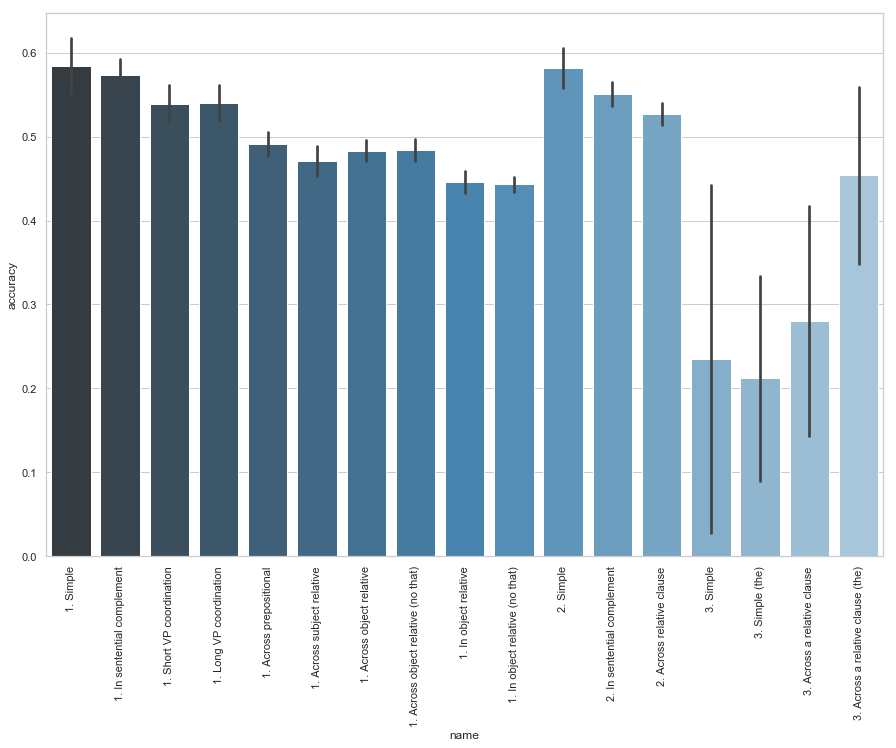

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
g = sns.barplot(
    data=lm_df, x='name', y='accuracy', ax=ax, palette="Blues_d", order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)
plt.savefig('figures/syneval/lm.pdf', bbox_inches='tight')

Capitalize versus not.

In [32]:
lm_dfs_caps = [
    pd.read_csv(f'../models/{folder}/output/syneval_results_caps.tsv', sep='\t') 
    for folder in lm_folders
]
lm_df_caps = get_results_as_dataframe(lm_dfs_caps, 'lm', rename_dict=NAME_DICT_FANCY)

In [33]:
lm_df['case'] = 'lowercase'
lm_df_caps['case'] = 'caps'

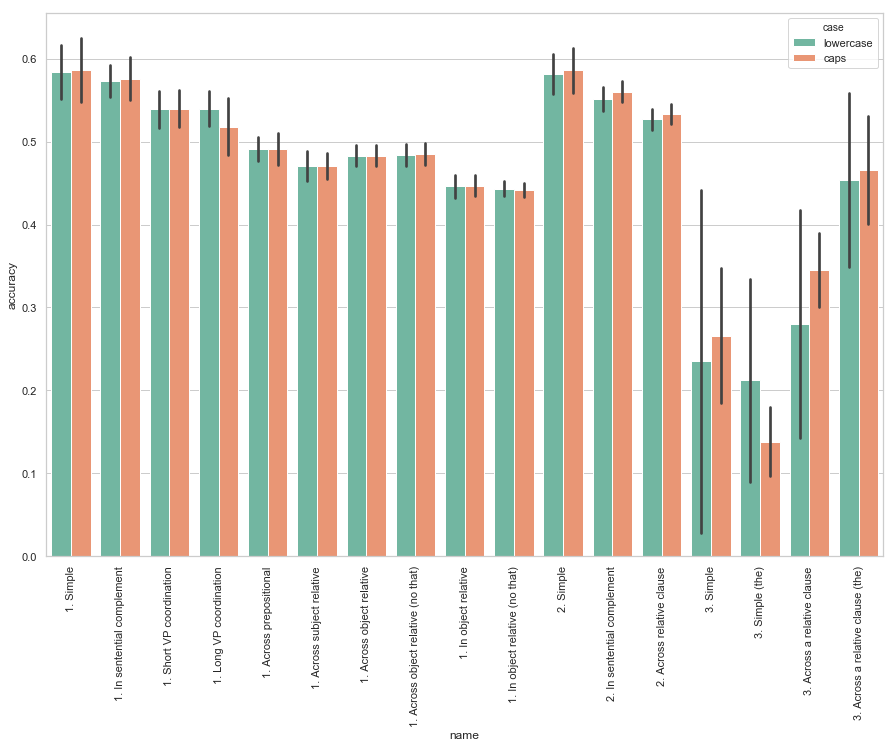

In [34]:
lm_both = pd.concat([lm_df, lm_df_caps])

fig, ax = plt.subplots(figsize=(15, 10))
g = sns.barplot(
    data=lm_both, x='name', y='accuracy', ax=ax, palette='Set2', order=FANCY, ci='sd', hue='case')
labels = plt.xticks(rotation=90)
plt.savefig('figures/syneval/lm_caps-no-caps.pdf', bbox_inches='tight')

Without UNK sentences.

In [22]:
lm_nounk_df = get_results_as_dataframe(lm_dfs, 'lm no-unk', rename_dict=NAME_DICT_FANCY, exclude_unks=True)

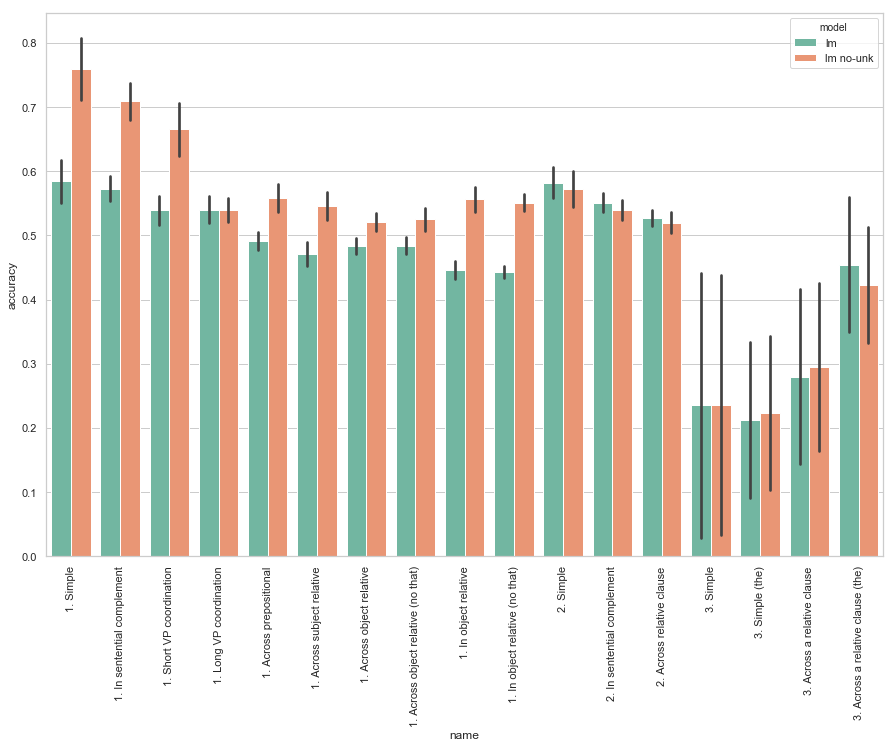

In [49]:
lm_both = pd.concat([lm_df, lm_nounk_df])

fig, ax = plt.subplots(figsize=(15, 10))
g = sns.barplot(
    data=lm_both, x='name', y='accuracy', ax=ax, palette='Set2', order=FANCY, ci='sd', hue='model')
labels = plt.xticks(rotation=90)
plt.savefig('figures/syneval/lm_unk-no-unk.pdf', bbox_inches='tight')

## Multitask models

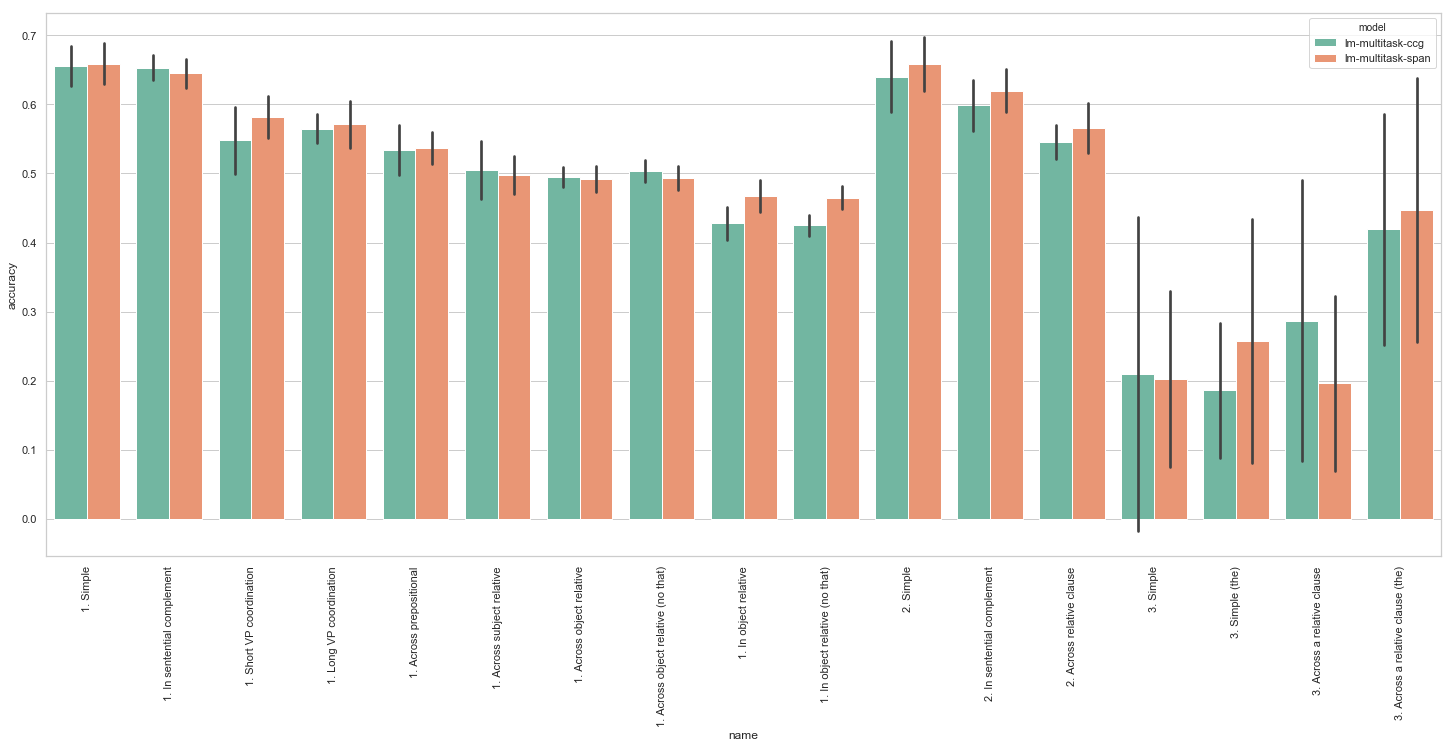

In [16]:
ccg_folders = filter_folders(all_folders, 'lm-multitask-ccg')
span_folders = filter_folders(all_folders, 'lm-multitask-span')

ccg_dfs = [
    pd.read_csv(f'../models/{folder}/output/syneval_results.tsv', sep='\t') 
    for folder in ccg_folders
]
span_dfs = [
    pd.read_csv(f'../models/{folder}/output/syneval_results.tsv', sep='\t') 
    for folder in span_folders
]

ccg_df = get_results_as_dataframe(
    ccg_dfs, 'lm-multitask-ccg', rename_dict=NAME_DICT_FANCY)
span_df = get_results_as_dataframe(
    span_dfs, 'lm-multitask-span', rename_dict=NAME_DICT_FANCY)

multi_df = pd.concat([ccg_df, span_df])

fig, ax = plt.subplots(figsize=(25, 10))
g = sns.barplot(
    data=multi_df, x='name', y='accuracy', ax=ax, palette="Set2", hue='model', order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)
plt.savefig('figures/syneval/mulitask-lm.pdf', bbox_inches='tight')

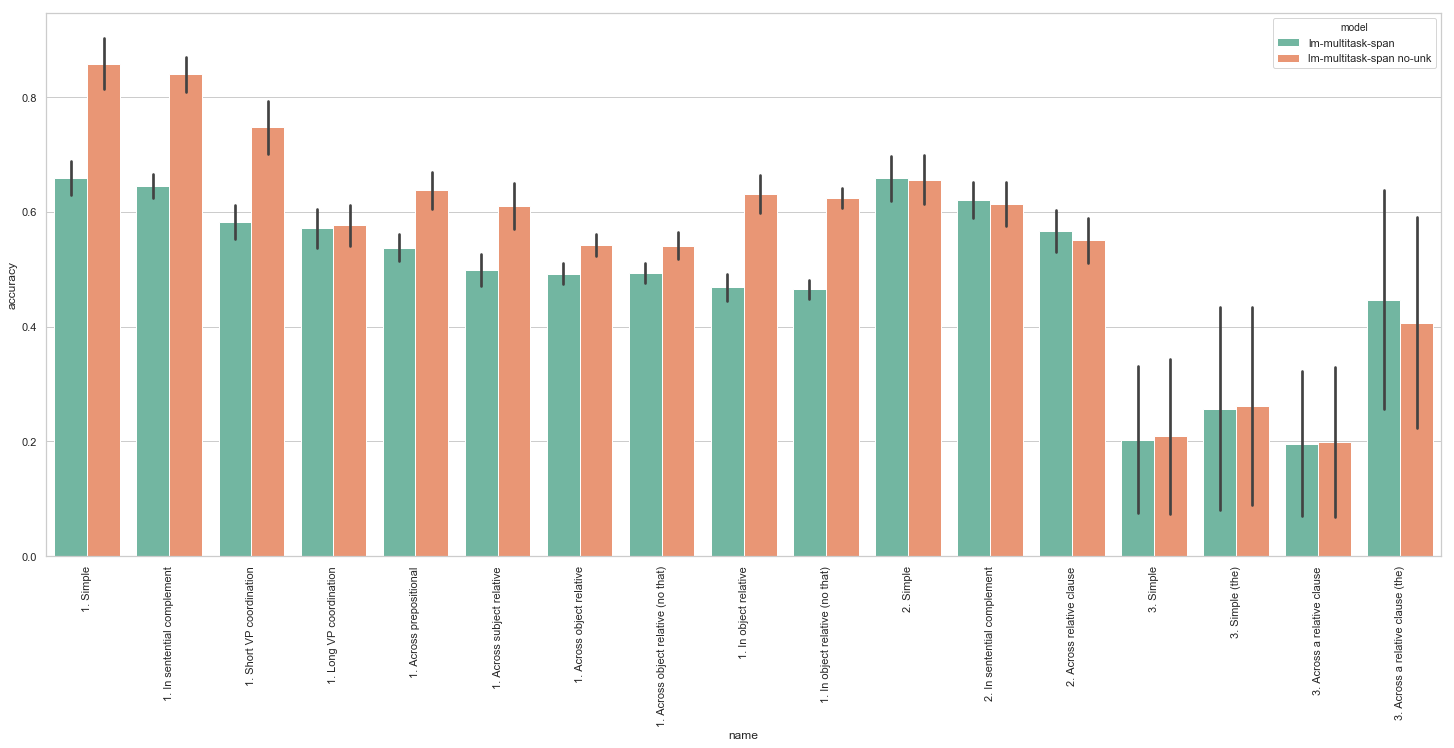

In [52]:
span_folders = filter_folders(all_folders, 'lm-multitask-span')

span_dfs = [
    pd.read_csv(f'../models/{folder}/output/syneval_results.tsv', sep='\t') 
    for folder in span_folders
]

span_df = get_results_as_dataframe(
    span_dfs, 'lm-multitask-span', rename_dict=NAME_DICT_FANCY)

span_nounk_df = get_results_as_dataframe(
    span_dfs, 'lm-multitask-span no-unk', rename_dict=NAME_DICT_FANCY, exclude_unks=True)

multi_both_df = pd.concat([span_df, span_nounk_df])

fig, ax = plt.subplots(figsize=(25, 10))
g = sns.barplot(
    data=multi_both_df, x='name', y='accuracy', ax=ax, palette="Set2", hue='model', order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)
plt.savefig('figures/syneval/mulitask-lm-span_unk-no-unk.pdf', bbox_inches='tight')

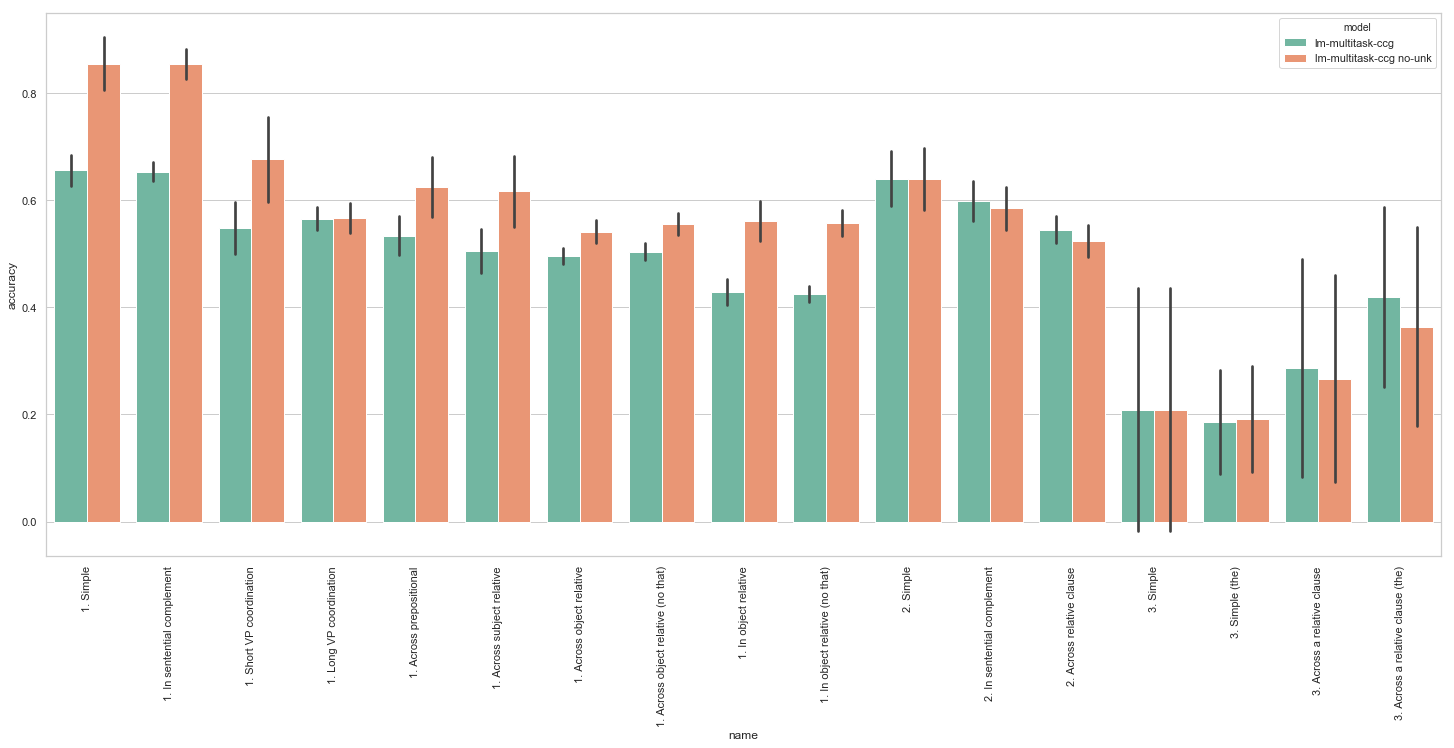

In [53]:
ccg_folders = filter_folders(all_folders, 'lm-multitask-ccg')

ccg_dfs = [
    pd.read_csv(f'../models/{folder}/output/syneval_results.tsv', sep='\t') 
    for folder in ccg_folders
]

ccg_df = get_results_as_dataframe(
    ccg_dfs, 'lm-multitask-ccg', rename_dict=NAME_DICT_FANCY)

ccg_nounk_df = get_results_as_dataframe(
    ccg_dfs, 'lm-multitask-ccg no-unk', rename_dict=NAME_DICT_FANCY, exclude_unks=True)

multi_both_df = pd.concat([ccg_df, ccg_nounk_df])

fig, ax = plt.subplots(figsize=(25, 10))
g = sns.barplot(
    data=multi_both_df, x='name', y='accuracy', ax=ax, palette="Set2", hue='model', order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)
plt.savefig('figures/syneval/mulitask-lm-ccg_unk-no-unk.pdf', bbox_inches='tight')

## All LMs

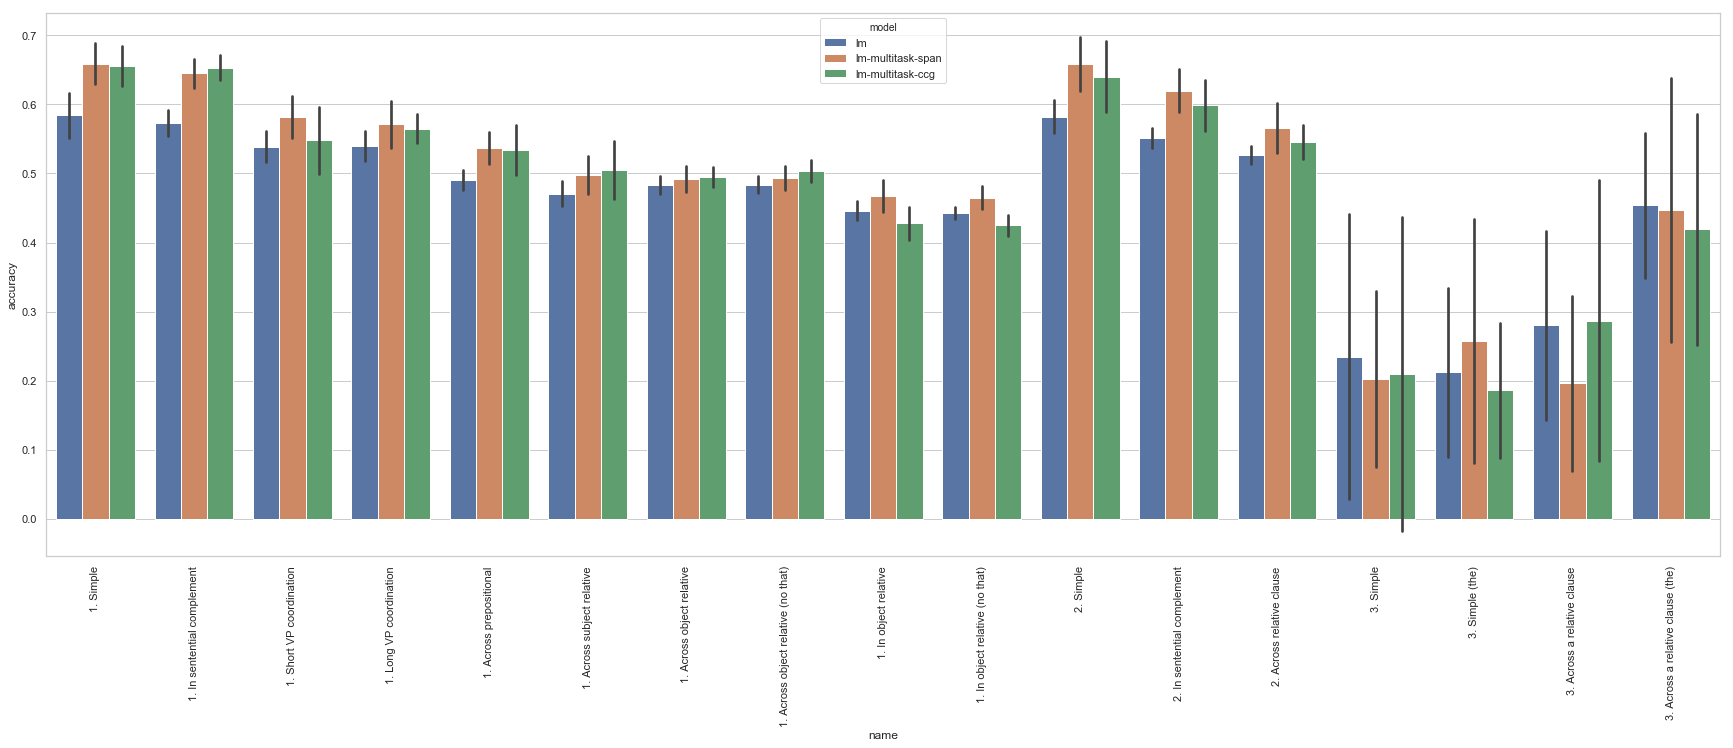

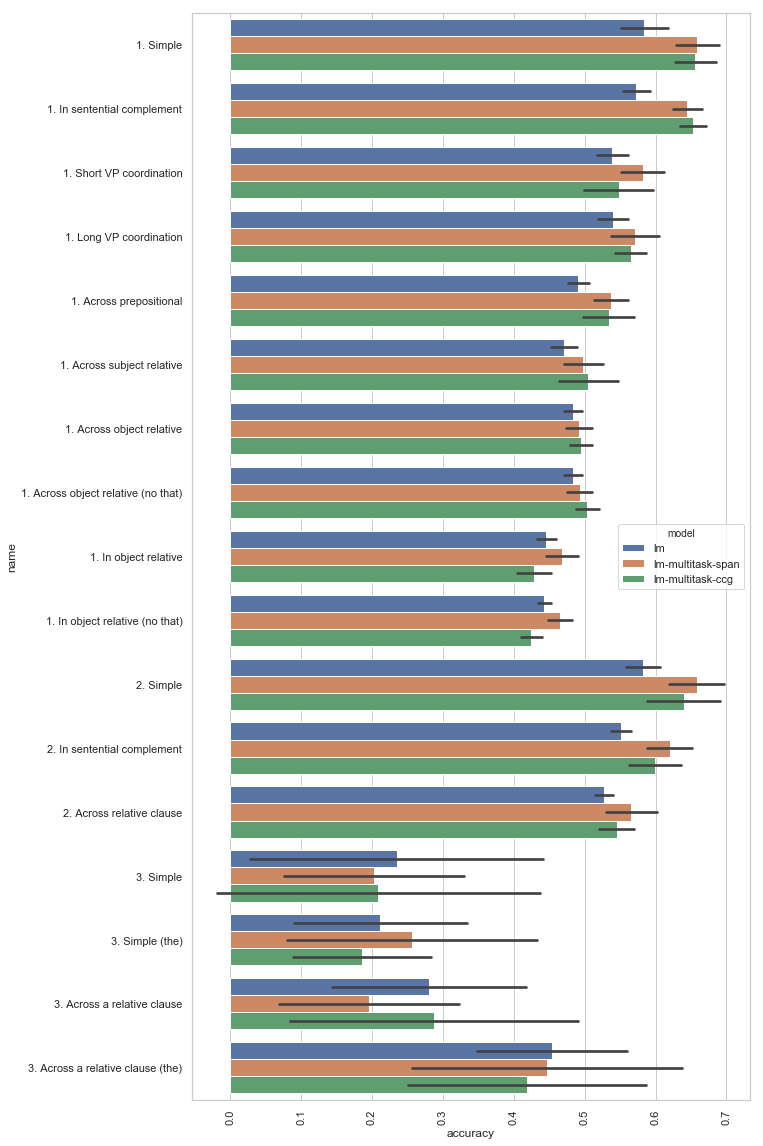

In [36]:
lm_both = pd.concat([lm_df, span_df, ccg_df])

fig, ax = plt.subplots(figsize=(30, 10))
g = sns.barplot(
    data=lm_both, x='name', y='accuracy', hue='model', ax=ax, order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)
plt.savefig('figures/syneval/lm-all.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(10, 20))
g = sns.barplot(
    data=lm_both, y='name', x='accuracy', hue='model', ax=ax, order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)
plt.savefig('figures/syneval/lm-all-vertical.pdf', bbox_inches='tight')

# RNNG

In [10]:
rnng_folders = filter_folders(all_folders, 'gen-rnng')
rnng_folders

['gen-rnng_dev=100.91',
 'gen-rnng_dev=100.93',
 'gen-rnng_dev=101.33',
 'gen-rnng_dev=101.48',
 'gen-rnng_dev=102.06',
 'gen-rnng_dev=102.29',
 'gen-rnng_dev=102.32',
 'gen-rnng_dev=102.33',
 'gen-rnng_dev=102.58',
 'gen-rnng_dev=103.74']

In [18]:
# rnng_dfs = [
#     pd.read_csv(f'../models/gen-rnng_dev=90.92/output/syneval_results_{i}.tsv', sep='\t') 
#     for i in range(1, 16)
# ]

rnng_dfs = [
    pd.read_csv(f'../models/{folder}/output/syneval_results.tsv', sep='\t') 
    for folder in rnng_folders
]

rnng_df = get_results_as_dataframe(rnng_dfs, 'rnng', rename_dict=NAME_DICT_FANCY)

rnng_nounk_df = get_results_as_dataframe(rnng_dfs, 'rnng no-unk', rename_dict=NAME_DICT_FANCY, exclude_unks=True)

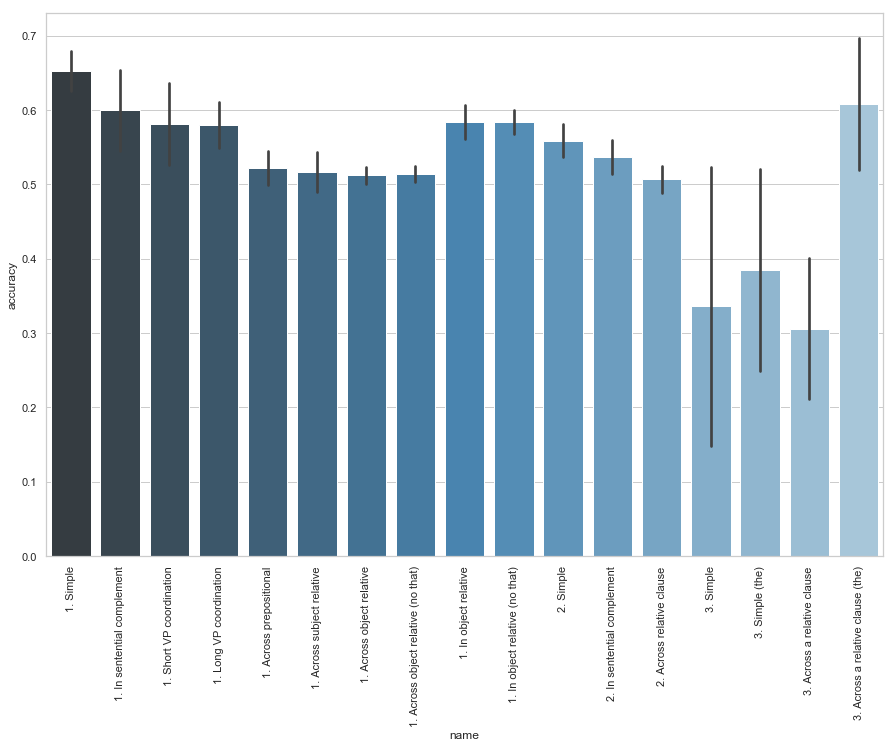

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
g = sns.barplot(
    data=rnng_df, x='name', y='accuracy', ax=ax, palette="Blues_d", order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)

plt.savefig('figures/syneval/rnng.pdf', bbox_inches='tight')

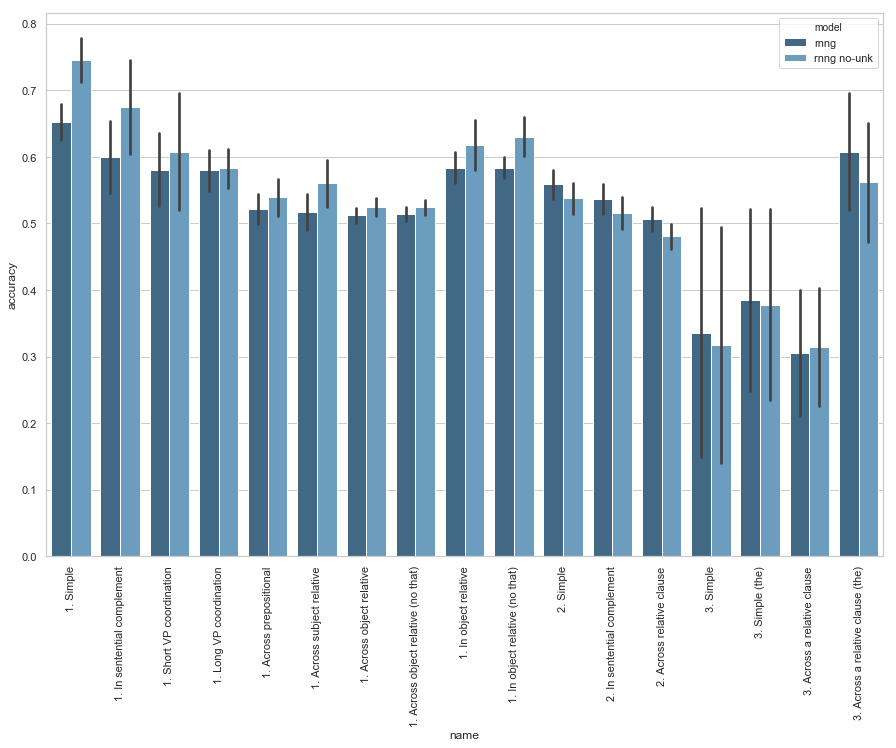

In [20]:
rnng_both = pd.concat([rnng_df, rnng_nounk_df])

fig, ax = plt.subplots(figsize=(15, 10))
g = sns.barplot(
    data=rnng_both, x='name', y='accuracy', ax=ax, palette="Blues_d", hue='model', order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)

plt.savefig('figures/syneval/rnng_unk-no-unk.pdf', bbox_inches='tight')

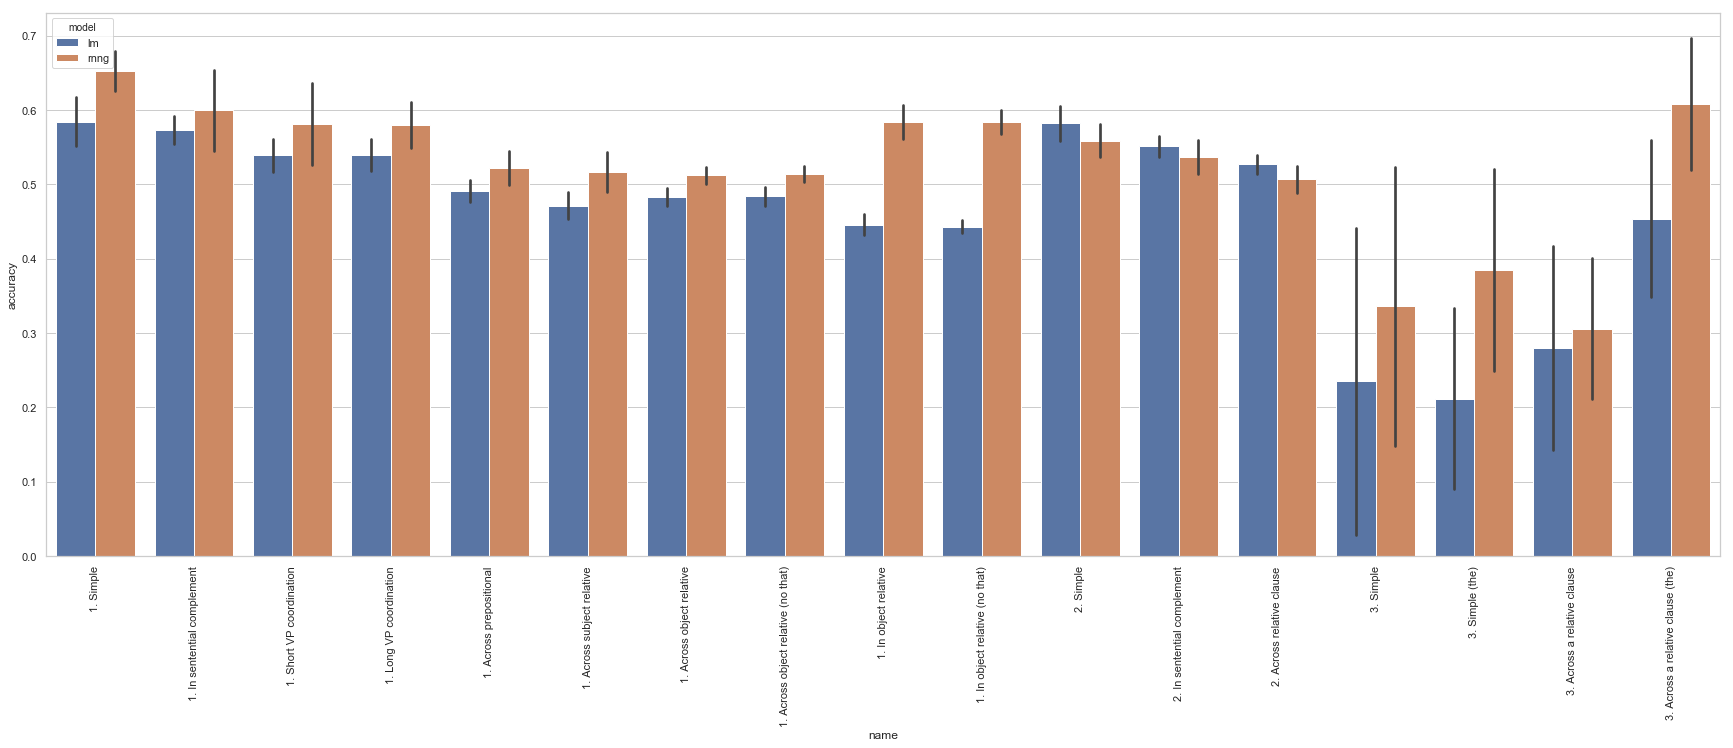

In [14]:
lm_rnng = pd.concat([lm_df, rnng_df])

fig, ax = plt.subplots(figsize=(30, 10))
g = sns.barplot(
    data=lm_rnng, x='name', y='accuracy', hue='model', ax=ax, order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)

plt.savefig('figures/syneval/lm-rnng.pdf', bbox_inches='tight')

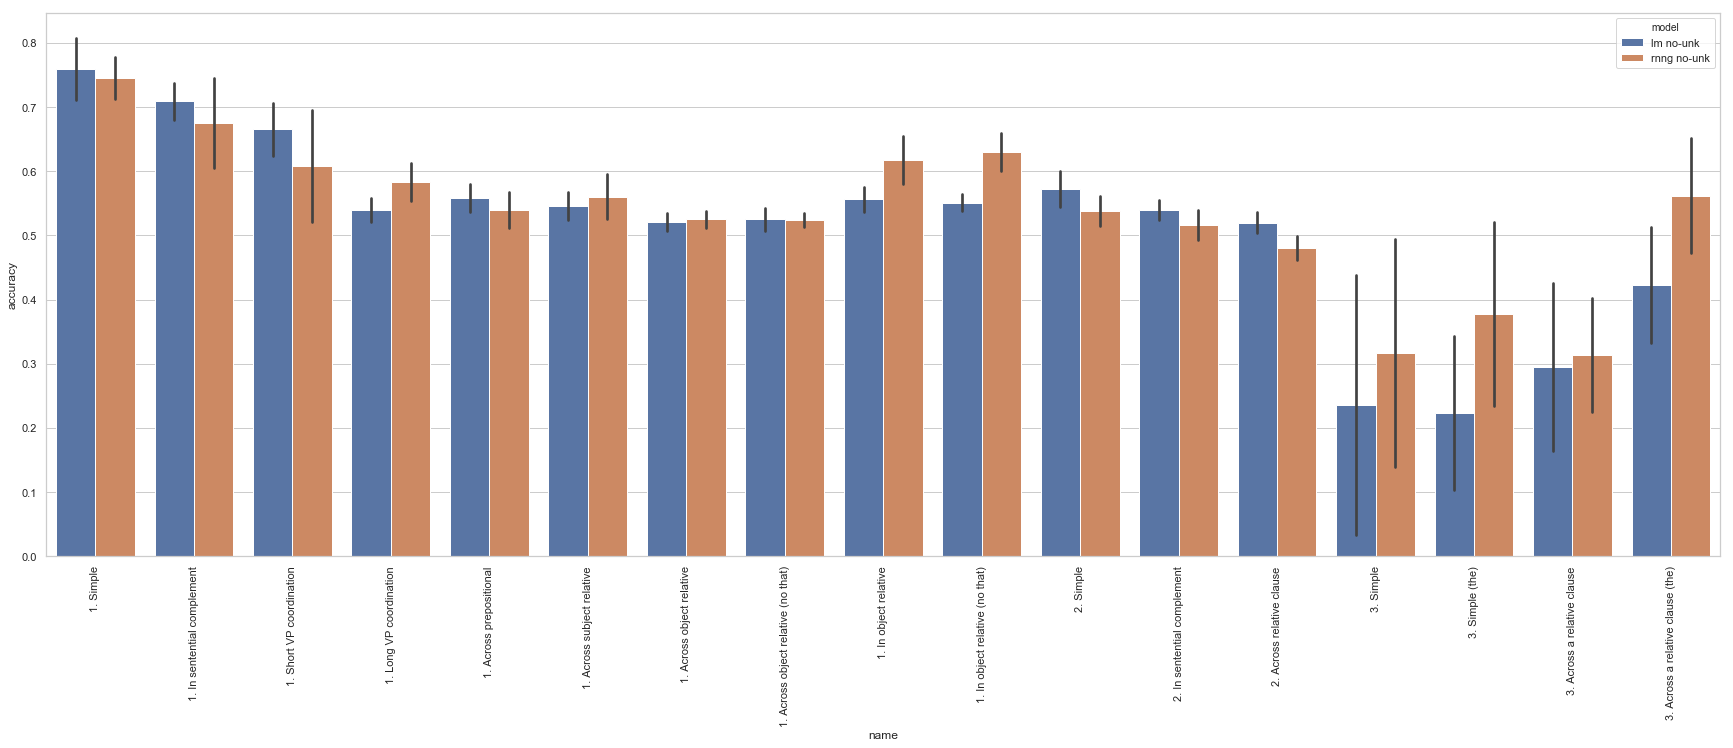

In [23]:
lm_rnng_nounk = pd.concat([lm_nounk_df, rnng_nounk_df])

fig, ax = plt.subplots(figsize=(30, 10))
g = sns.barplot(
    data=lm_rnng_nounk, x='name', y='accuracy', hue='model', ax=ax, order=FANCY, ci='sd')
labels = plt.xticks(rotation=90)

plt.savefig('figures/syneval/lm-rnng_unk-no-unk.pdf', bbox_inches='tight')

# All three together

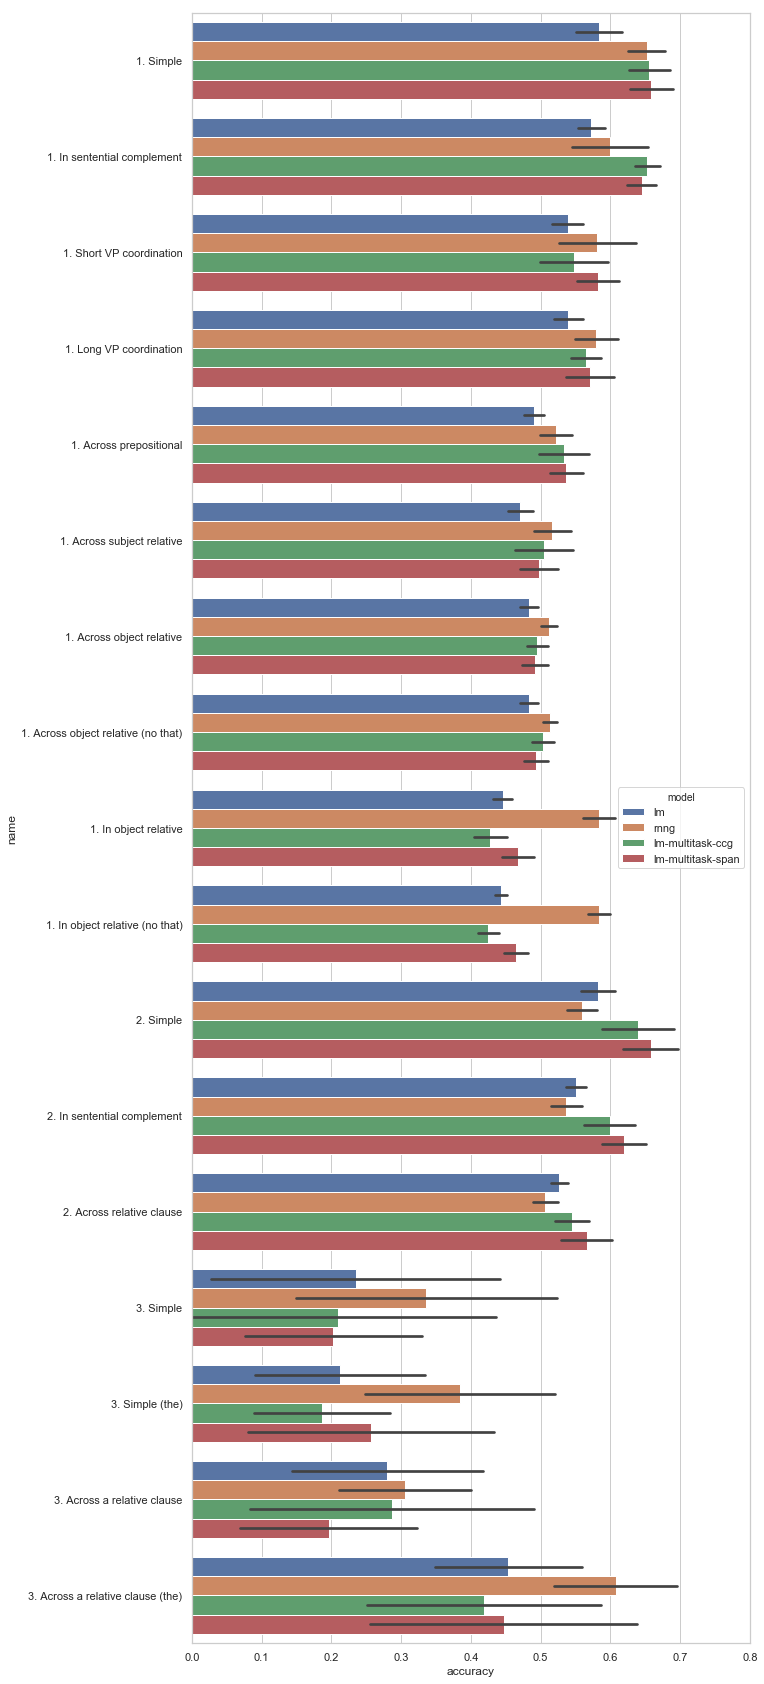

In [27]:
lm_all = pd.concat([lm_df, rnng_df, multi_df])

fig, ax = plt.subplots(figsize=(10, 30))
g = sns.barplot(
    data=lm_all, y='name', x='accuracy', hue='model', ax=ax, order=FANCY, ci='sd')

plt.xlim(0, 0.8)

plt.savefig('figures/syneval/all.pdf', bbox_inches='tight')

# Remove pairs with UNK

In [208]:
rnng_nounk_df = get_results_as_dataframe(
    rnng_dfs, 'rnng-no-unk', exclude_unks=True)

multi_nounk_df = get_results_as_dataframe(
    only_multi_dfs, 'multitask-lm-no-unk', exclude_unks=True)

lm_nounk_df = get_results_as_dataframe(
    lm_dfs, 'lm-no-unk', exclude_unks=True)

In [ ]:
lm_all = pd.concat([lm_df, lm_nounk_df])

fig, ax = plt.subplots(figsize=(40, 10))
g = sns.barplot(
    data=lm_all, x='name', y='accuracy', hue='model', ax=ax, order=ALL, ci='sd')
labels = plt.xticks(rotation=30)

In [ ]:
lm_all = pd.concat([multi_df, multi_nounk_df])

fig, ax = plt.subplots(figsize=(40, 10))
g = sns.barplot(
    data=lm_all, x='name', y='accuracy', hue='model', ax=ax, order=ALL, ci='sd')
labels = plt.xticks(rotation=30)

In [ ]:
lm_all = pd.concat([rnng_df, rnng_nounk_df])

fig, ax = plt.subplots(figsize=(40, 10))
g = sns.barplot(
    data=lm_all, x='name', y='accuracy', hue='model', ax=ax, order=ALL, ci='sd')
labels = plt.xticks(rotation=30)

In [ ]:
lm_all = pd.concat([lm_nounk_df, rnng_nounk_df, multi_nounk_df])

fig, ax = plt.subplots(figsize=(40, 10))
g = sns.barplot(
    data=lm_all, x='name', y='accuracy', hue='model', ax=ax, order=ALL, ci='sd')
labels = plt.xticks(rotation=30)

plt.savefig('figs/all-syneval-no-unk.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 30))
g = sns.barplot(
    data=lm_all, y='name', x='accuracy', hue='model', ax=ax, order=ALL, ci='sd')

plt.savefig('figs/all-syneval-no-unk.pdf', bbox_inches='tight')

# Compare predictions

In [ ]:
fpath ='../models/lm_dev=120.75/output/syneval_results.tsv'
lm_df = pd.read_csv(fpath, sep='\t')
lm_df['model'] = 'lm'

fpath ='../models/multitask-lm_seed=4_dev=136.3/output/syneval_results.tsv'
multi_df = pd.read_csv(fpath, sep='\t')
multi_df['model'] = 'multitask-lm'

In [ ]:
n = len(lm_df)
same = (lm_df['correct'] == multi_df['correct']).sum() / n
better = (-lm_df['correct'] == multi_df['correct']).sum() / n

print(same)
print(better)

In [ ]:
lm_df['difference'] = lm_df['neg-perplexity'] - lm_df['pos-perplexity']

In [ ]:
sorted_lm_df = lm_df.sort_values(by='difference', ascending=False)

In [ ]:
select(sorted_lm_df, 'vp_coord')

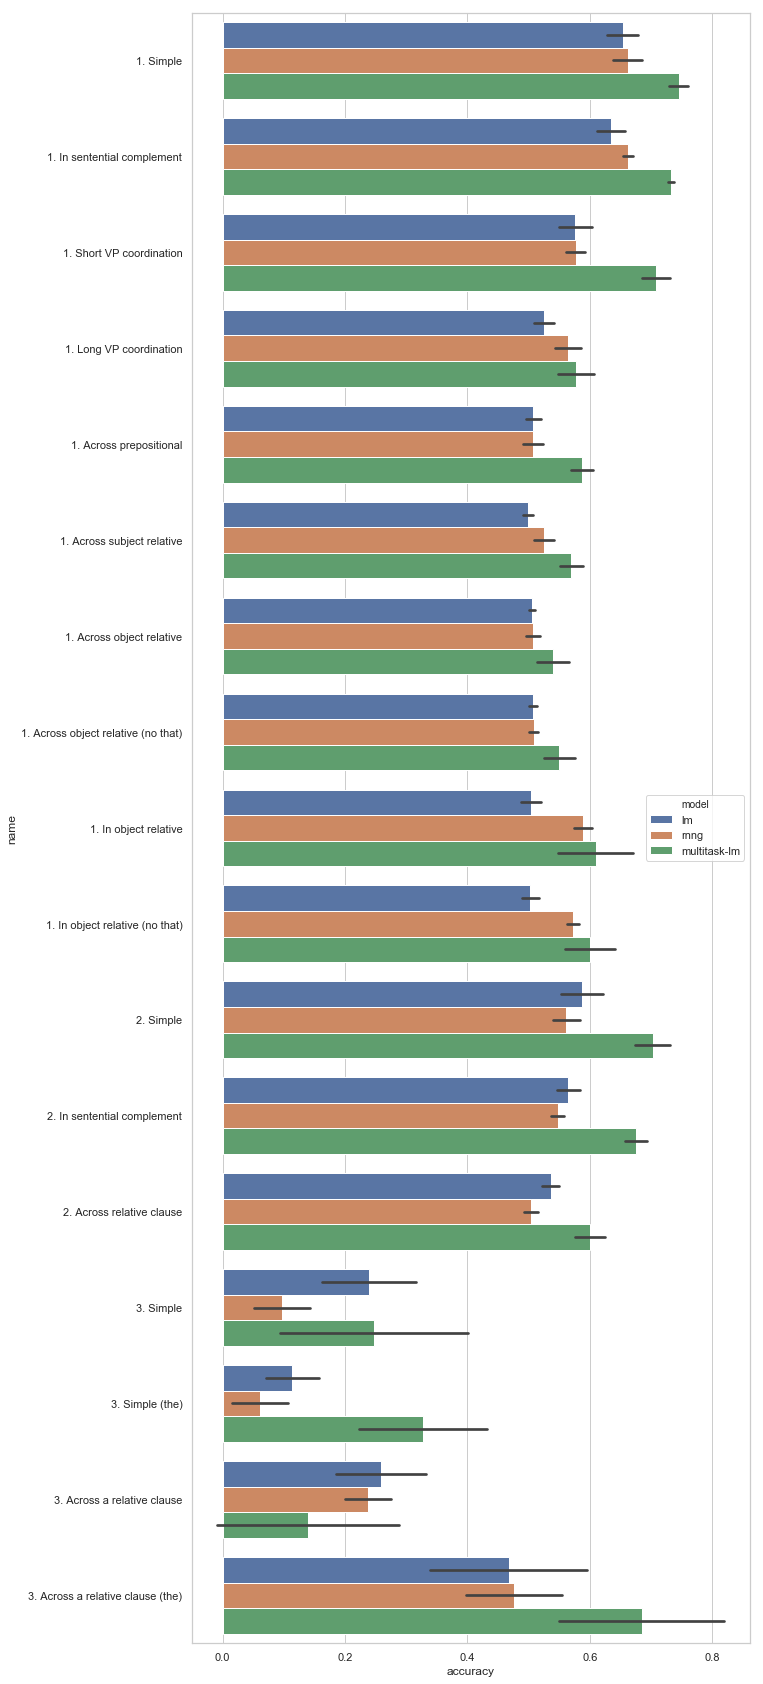

In [56]:
fig, ax = plt.subplots(figsize=(10, 30))
g = sns.barplot(
    data=lm_all, y='name', x='accuracy', hue='model', ax=ax, order=FANCY, ci='sd')

plt.savefig('figs/all-syneval-no-unk.pdf', bbox_inches='tight')